In [54]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
from keras.losses import mean_absolute_error
from keras.losses import mean_squared_error
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.utils import plot_model
import tensorflow as tf

from LRF import LRFinder
from SGDR import SGDRScheduler
from xception import Xception


In [66]:
train_path = './Data/images'
val_path = './Data/images'
architecture_plot_save_dir = '.'

img_width, img_height = 299., 299.
rx = 2.1404
ry = 1.61

In [67]:
base_dir = '.'
epochs = 1000
chkpt_dir = './chkpts/xception_augmented.h5'

In [68]:
base_model = Xception(include_top=False, weights=None, input_shape = (299, 299, 3), classes = 4)

In [69]:
# for layer in base_model.layers[:-3]:
#     layer.trainable= False

In [70]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(4, activation="relu")(x)

In [71]:
model = Model(input = base_model.input, output = predictions)
# model = load_model('X:/hf/chkpts/xception_aiming_94pt4.h5', custom_objects = {'mIoU':mIoU})
# plot_model(model, os.path.join(architecture_plot_save_dir, 'xception.png'))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [72]:
# model.load_weights("X:/hf - Object Localization (Medium Complexity Round)/chkpts/xception_lrf_training_s3_mix.h5.h5")

In [73]:
def mIoU(labels,predictions):
    pred_x1=predictions[:,0]
    pred_x2=predictions[:,1]
    pred_y1=predictions[:,2]
    pred_y2=predictions[:,3]
    label_x1=labels[:,0]
    label_x2=labels[:,1]
    label_y1=labels[:,2]
    label_y2=labels[:,3]
    int_x1 = tf.maximum(pred_x1, label_x1)
    int_x2 = tf.minimum(pred_x2, label_x2)
    int_y1 = tf.maximum(pred_y1, label_y1)
    int_y2 = tf.minimum(pred_y2, label_y2)
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    int_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), int_x2 - int_x1), tf.maximum(tf.cast(0.0, tensor_type), int_y2 - int_y1))
    union_area = pred_area + label_area - int_area
    IoU = int_area / union_area
    return tf.reduce_mean(IoU)

In [74]:
train_df = pd.read_csv('C:/Users/praty/train.csv')
train_df.tail()

,image_name,x1,x2,y1,y2
163,164.jpg,83,369,34,483
164,165.jpg,365,776,245,479
165,166.jpg,1017,1272,615,678
166,167.jpg,259,326,214,263
167,168.jpg,86,239,18,58


In [75]:
val_df = pd.read_csv('C:/Users/praty/val.csv')
val_df.tail()

,image_name,x1,x2,y1,y2
27,196.jpg,333,646,934,1062
28,197.jpg,535,778,381,474
29,198.jpg,3,250,22,189
30,199.jpg,88,136,99,128
31,200.jpg,80,199,126,184


In [76]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory=train_path,
                                                  x_col='image_name',
                                                  y_col=['x1', 'x2', 'y1', 'y2'],
                                                  class_mode="other",
                                                  target_size = (299, 299),
                                                  batch_size=16,
                                                  shuffle = True)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=val_df,
                                                  directory=val_path,
                                                  x_col='image_name',
                                                  y_col=['x1', 'x2', 'y1', 'y2'],
                                                  class_mode="other",
                                                  target_size = (299, 299),
                                                  batch_size=16,
                                                  shuffle = True)

Found 168 images.
Found 32 images.


In [77]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [78]:
def custom_loss_with_area(y_true, y_pred):
    pred_x1=y_pred[:,0]
    pred_x2=y_pred[:,1]
    pred_y1=y_pred[:,2]
    pred_y2=y_pred[:,3]
    label_x1=y_true[:,0]
    label_x2=y_true[:,1]
    label_y1=y_true[:,2]
    label_y2=y_true[:,3]
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    return mean_absolute_error(y_true, y_pred) * (2 - iou) + tf.cast(3.0, tensor_type) * tf.reduce_mean(tf.abs(label_area - pred_area) / label_area)

In [79]:
def custom_loss(y_true, y_pred):
    iou = mIoU(y_true, y_pred)
    return mean_absolute_error(y_true, y_pred) * (2 - iou)

In [80]:
model.compile(loss = custom_loss, optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=[mIoU])

In [81]:
checkpoint = ModelCheckpoint(chkpt_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

In [82]:
lrf = LRFinder(minimum=1e-5, maximum=1e-3, step_size=(train_generator.n//train_generator.batch_size), n_epochs=2)

In [83]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    verbose=1,
                    callbacks=[checkpoint, lrf],
                    shuffle=True)

Epoch 1/2
10/10 [==============================] - 9s 931ms/step - loss: 594.0574 - mIoU: 5.2701e-06 - val_loss: 407.7351 - val_mIoU: 3.3053e-04

Epoch 00001: val_loss improved from inf to 407.73511, saving model to ./chkpts/xception_augmented.h5
Epoch 2/2
10/10 [==============================] - 5s 512ms/step - loss: 299.0908 - mIoU: 0.0500 - val_loss: 33512.3594 - val_mIoU: 0.0054

Epoch 00002: val_loss did not improve from 407.73511


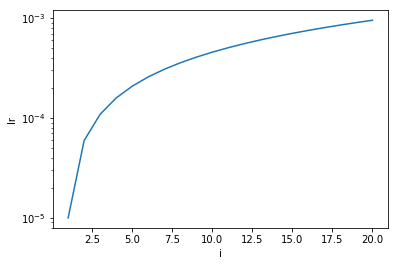

In [84]:
lrf.lr_graph()

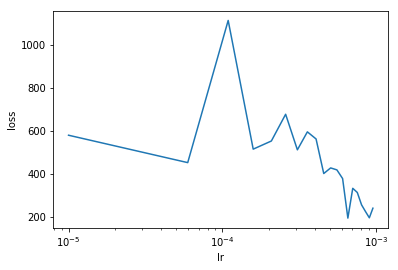

In [85]:
lrf.loss_graph()

In [86]:
schedule = SGDRScheduler(min_lr=8e-5,
                         max_lr=9e-4,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         lr_decay=0.9,
                         cycle_length=2,
                         mult_factor=1.5)

In [87]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1023,
                    verbose=1,
                    callbacks=[checkpoint, schedule],
                    shuffle=True)

Epoch 1/1023
10/10 [==============================] - 5s 522ms/step - loss: 280.4695 - mIoU: 0.0966 - val_loss: 122884.0156 - val_mIoU: 0.0000e+00

Epoch 00001: val_loss did not improve from 407.73511
Epoch 2/1023
10/10 [==============================] - 5s 512ms/step - loss: 237.1496 - mIoU: 0.1227 - val_loss: 11848.1079 - val_mIoU: 0.0116

Epoch 00002: val_loss did not improve from 407.73511
Epoch 3/1023
10/10 [==============================] - 5s 513ms/step - loss: 329.4605 - mIoU: 0.0653 - val_loss: 36709.4121 - val_mIoU: 0.0027

Epoch 00003: val_loss did not improve from 407.73511
Epoch 4/1023
10/10 [==============================] - 5s 512ms/step - loss: 216.8313 - mIoU: 0.1275 - val_loss: 5093.1987 - val_mIoU: 0.0646

Epoch 00004: val_loss did not improve from 407.73511
Epoch 5/1023
10/10 [==============================] - 5s 514ms/step - loss: 282.9810 - mIoU: 0.1026 - val_loss: 2417.2306 - val_mIoU: 0.0604

Epoch 00005: val_loss did not improve from 407.73511
Epoch 6/1023
10/1

10/10 [==============================] - 5s 515ms/step - loss: 65.8349 - mIoU: 0.4136 - val_loss: 295.9423 - val_mIoU: 0.1043

Epoch 00084: val_loss did not improve from 251.79662
Epoch 85/1023
10/10 [==============================] - 5s 514ms/step - loss: 63.7978 - mIoU: 0.4300 - val_loss: 272.3417 - val_mIoU: 0.1229

Epoch 00085: val_loss did not improve from 251.79662
Epoch 86/1023
10/10 [==============================] - 5s 515ms/step - loss: 57.4646 - mIoU: 0.4200 - val_loss: 282.3338 - val_mIoU: 0.0928

Epoch 00086: val_loss did not improve from 251.79662
Epoch 87/1023
10/10 [==============================] - 5s 515ms/step - loss: 59.8098 - mIoU: 0.4134 - val_loss: 272.8385 - val_mIoU: 0.1246

Epoch 00087: val_loss did not improve from 251.79662
Epoch 88/1023
10/10 [==============================] - 5s 515ms/step - loss: 55.1470 - mIoU: 0.4298 - val_loss: 259.2088 - val_mIoU: 0.1152

Epoch 00088: val_loss did not improve from 251.79662
Epoch 89/1023
10/10 [=======================

10/10 [==============================] - 5s 517ms/step - loss: 13.2917 - mIoU: 0.7357 - val_loss: 259.0307 - val_mIoU: 0.1057

Epoch 00168: val_loss did not improve from 251.79662
Epoch 169/1023
10/10 [==============================] - 5s 517ms/step - loss: 11.2322 - mIoU: 0.7595 - val_loss: 260.6002 - val_mIoU: 0.1156

Epoch 00169: val_loss did not improve from 251.79662
Epoch 170/1023
10/10 [==============================] - 5s 495ms/step - loss: 10.9820 - mIoU: 0.7909 - val_loss: 260.3896 - val_mIoU: 0.1199

Epoch 00170: val_loss did not improve from 251.79662
Epoch 171/1023
10/10 [==============================] - 5s 540ms/step - loss: 9.5899 - mIoU: 0.7822 - val_loss: 262.2667 - val_mIoU: 0.1106

Epoch 00171: val_loss did not improve from 251.79662
Epoch 172/1023
10/10 [==============================] - 5s 517ms/step - loss: 15.4610 - mIoU: 0.7243 - val_loss: 264.9995 - val_mIoU: 0.1158

Epoch 00172: val_loss did not improve from 251.79662
Epoch 173/1023
10/10 [===================

10/10 [==============================] - 5s 517ms/step - loss: 21.5419 - mIoU: 0.6463 - val_loss: 279.9415 - val_mIoU: 0.0867

Epoch 00210: val_loss did not improve from 247.45356
Epoch 211/1023
10/10 [==============================] - 5s 517ms/step - loss: 23.0832 - mIoU: 0.6343 - val_loss: 269.9183 - val_mIoU: 0.0910

Epoch 00211: val_loss did not improve from 247.45356
Epoch 212/1023
10/10 [==============================] - 5s 517ms/step - loss: 23.0655 - mIoU: 0.6437 - val_loss: 256.9803 - val_mIoU: 0.1285

Epoch 00212: val_loss did not improve from 247.45356
Epoch 213/1023
10/10 [==============================] - 5s 517ms/step - loss: 21.4262 - mIoU: 0.6669 - val_loss: 256.5808 - val_mIoU: 0.1365

Epoch 00213: val_loss did not improve from 247.45356
Epoch 214/1023
10/10 [==============================] - 5s 539ms/step - loss: 20.3480 - mIoU: 0.6517 - val_loss: 251.9229 - val_mIoU: 0.1375

Epoch 00214: val_loss did not improve from 247.45356
Epoch 215/1023
10/10 [==================

10/10 [==============================] - 5s 495ms/step - loss: 28.4547 - mIoU: 0.5846 - val_loss: 272.5898 - val_mIoU: 0.0925

Epoch 00294: val_loss did not improve from 247.45356
Epoch 295/1023
10/10 [==============================] - 5s 544ms/step - loss: 24.5396 - mIoU: 0.6143 - val_loss: 271.4059 - val_mIoU: 0.0846

Epoch 00295: val_loss did not improve from 247.45356
Epoch 296/1023
10/10 [==============================] - 5s 519ms/step - loss: 19.3118 - mIoU: 0.6690 - val_loss: 272.7074 - val_mIoU: 0.0910

Epoch 00296: val_loss did not improve from 247.45356
Epoch 297/1023
10/10 [==============================] - 5s 516ms/step - loss: 22.9350 - mIoU: 0.6642 - val_loss: 285.4511 - val_mIoU: 0.0754

Epoch 00297: val_loss did not improve from 247.45356
Epoch 298/1023
10/10 [==============================] - 5s 517ms/step - loss: 20.7516 - mIoU: 0.6651 - val_loss: 258.5792 - val_mIoU: 0.1263

Epoch 00298: val_loss did not improve from 247.45356
Epoch 299/1023
10/10 [==================

10/10 [==============================] - 5s 517ms/step - loss: 6.6498 - mIoU: 0.8382 - val_loss: 257.1236 - val_mIoU: 0.1203

Epoch 00378: val_loss did not improve from 247.45356
Epoch 379/1023
10/10 [==============================] - 5s 519ms/step - loss: 8.4975 - mIoU: 0.8028 - val_loss: 256.9613 - val_mIoU: 0.1193

Epoch 00379: val_loss did not improve from 247.45356
Epoch 380/1023
10/10 [==============================] - 5s 518ms/step - loss: 7.9913 - mIoU: 0.8122 - val_loss: 259.7914 - val_mIoU: 0.1101

Epoch 00380: val_loss did not improve from 247.45356
Epoch 381/1023
10/10 [==============================] - 5s 540ms/step - loss: 7.4741 - mIoU: 0.8446 - val_loss: 256.6331 - val_mIoU: 0.1147

Epoch 00381: val_loss did not improve from 247.45356
Epoch 382/1023
10/10 [==============================] - 5s 517ms/step - loss: 7.7074 - mIoU: 0.8284 - val_loss: 257.8253 - val_mIoU: 0.1169

Epoch 00382: val_loss did not improve from 247.45356
Epoch 383/1023
10/10 [=======================

10/10 [==============================] - 5s 519ms/step - loss: 17.7698 - mIoU: 0.6820 - val_loss: 266.3572 - val_mIoU: 0.1194

Epoch 00462: val_loss did not improve from 247.45356
Epoch 463/1023
10/10 [==============================] - 5s 519ms/step - loss: 17.4785 - mIoU: 0.6548 - val_loss: 262.7721 - val_mIoU: 0.1142

Epoch 00463: val_loss did not improve from 247.45356
Epoch 464/1023
10/10 [==============================] - 5s 519ms/step - loss: 17.4636 - mIoU: 0.6746 - val_loss: 268.8250 - val_mIoU: 0.0946

Epoch 00464: val_loss did not improve from 247.45356
Epoch 465/1023
10/10 [==============================] - 5s 517ms/step - loss: 16.9785 - mIoU: 0.6770 - val_loss: 267.3124 - val_mIoU: 0.0949

Epoch 00465: val_loss did not improve from 247.45356
Epoch 466/1023
10/10 [==============================] - 5s 518ms/step - loss: 16.7803 - mIoU: 0.6728 - val_loss: 255.5820 - val_mIoU: 0.1258

Epoch 00466: val_loss did not improve from 247.45356
Epoch 467/1023
10/10 [==================

10/10 [==============================] - 5s 518ms/step - loss: 5.9509 - mIoU: 0.8427 - val_loss: 259.3834 - val_mIoU: 0.1003

Epoch 00546: val_loss did not improve from 247.45356
Epoch 547/1023
10/10 [==============================] - 5s 522ms/step - loss: 8.4851 - mIoU: 0.8091 - val_loss: 258.8203 - val_mIoU: 0.1046

Epoch 00547: val_loss did not improve from 247.45356
Epoch 548/1023
10/10 [==============================] - 5s 520ms/step - loss: 8.4995 - mIoU: 0.7977 - val_loss: 256.9651 - val_mIoU: 0.1161

Epoch 00548: val_loss did not improve from 247.45356
Epoch 549/1023
10/10 [==============================] - 5s 518ms/step - loss: 6.9504 - mIoU: 0.8316 - val_loss: 257.3490 - val_mIoU: 0.1132

Epoch 00549: val_loss did not improve from 247.45356
Epoch 550/1023
10/10 [==============================] - 5s 518ms/step - loss: 8.1426 - mIoU: 0.8117 - val_loss: 257.4782 - val_mIoU: 0.1086

Epoch 00550: val_loss did not improve from 247.45356
Epoch 551/1023
10/10 [=======================

10/10 [==============================] - 5s 518ms/step - loss: 16.9734 - mIoU: 0.6920 - val_loss: 253.7084 - val_mIoU: 0.1244

Epoch 00630: val_loss did not improve from 247.45356
Epoch 631/1023
10/10 [==============================] - 5s 518ms/step - loss: 18.1328 - mIoU: 0.6570 - val_loss: 254.7164 - val_mIoU: 0.1164

Epoch 00631: val_loss did not improve from 247.45356
Epoch 632/1023
10/10 [==============================] - 5s 541ms/step - loss: 17.2938 - mIoU: 0.6964 - val_loss: 263.6292 - val_mIoU: 0.1033

Epoch 00632: val_loss did not improve from 247.45356
Epoch 633/1023
10/10 [==============================] - 5s 495ms/step - loss: 15.0312 - mIoU: 0.7063 - val_loss: 261.5984 - val_mIoU: 0.1081

Epoch 00633: val_loss did not improve from 247.45356
Epoch 634/1023
10/10 [==============================] - 5s 540ms/step - loss: 14.5868 - mIoU: 0.7227 - val_loss: 260.8665 - val_mIoU: 0.1026

Epoch 00634: val_loss did not improve from 247.45356
Epoch 635/1023
10/10 [==================

10/10 [==============================] - 5s 516ms/step - loss: 10.3135 - mIoU: 0.7917 - val_loss: 257.0173 - val_mIoU: 0.1072

Epoch 00714: val_loss did not improve from 247.45356
Epoch 715/1023
10/10 [==============================] - 5s 516ms/step - loss: 9.4185 - mIoU: 0.7861 - val_loss: 262.9453 - val_mIoU: 0.0967

Epoch 00715: val_loss did not improve from 247.45356
Epoch 716/1023
10/10 [==============================] - 5s 516ms/step - loss: 11.5404 - mIoU: 0.7648 - val_loss: 262.6165 - val_mIoU: 0.0957

Epoch 00716: val_loss did not improve from 247.45356
Epoch 717/1023
10/10 [==============================] - 5s 516ms/step - loss: 10.1935 - mIoU: 0.7735 - val_loss: 261.1141 - val_mIoU: 0.1052

Epoch 00717: val_loss did not improve from 247.45356
Epoch 718/1023
10/10 [==============================] - 5s 516ms/step - loss: 11.0275 - mIoU: 0.7659 - val_loss: 260.2232 - val_mIoU: 0.1009

Epoch 00718: val_loss did not improve from 247.45356
Epoch 719/1023
10/10 [===================

10/10 [==============================] - 5s 538ms/step - loss: 7.1526 - mIoU: 0.8224 - val_loss: 256.4487 - val_mIoU: 0.1163

Epoch 00798: val_loss did not improve from 247.45356
Epoch 799/1023
10/10 [==============================] - 5s 515ms/step - loss: 7.5761 - mIoU: 0.8164 - val_loss: 254.7045 - val_mIoU: 0.1205

Epoch 00799: val_loss did not improve from 247.45356
Epoch 800/1023
10/10 [==============================] - 5s 516ms/step - loss: 8.0054 - mIoU: 0.8169 - val_loss: 259.0030 - val_mIoU: 0.1092

Epoch 00800: val_loss did not improve from 247.45356
Epoch 801/1023
10/10 [==============================] - 5s 518ms/step - loss: 7.1077 - mIoU: 0.8258 - val_loss: 258.7727 - val_mIoU: 0.1083

Epoch 00801: val_loss did not improve from 247.45356
Epoch 802/1023
10/10 [==============================] - 5s 522ms/step - loss: 8.1193 - mIoU: 0.8267 - val_loss: 258.3376 - val_mIoU: 0.1115

Epoch 00802: val_loss did not improve from 247.45356
Epoch 803/1023
10/10 [=======================

10/10 [==============================] - 5s 521ms/step - loss: 4.4108 - mIoU: 0.8868 - val_loss: 261.1098 - val_mIoU: 0.0962

Epoch 00882: val_loss did not improve from 247.45356
Epoch 883/1023
10/10 [==============================] - 5s 539ms/step - loss: 4.5511 - mIoU: 0.8814 - val_loss: 262.8258 - val_mIoU: 0.0933

Epoch 00883: val_loss did not improve from 247.45356
Epoch 884/1023
10/10 [==============================] - 5s 494ms/step - loss: 5.4707 - mIoU: 0.8645 - val_loss: 260.8100 - val_mIoU: 0.0958

Epoch 00884: val_loss did not improve from 247.45356
Epoch 885/1023
10/10 [==============================] - 5s 539ms/step - loss: 4.5988 - mIoU: 0.8643 - val_loss: 261.8583 - val_mIoU: 0.0982

Epoch 00885: val_loss did not improve from 247.45356
Epoch 886/1023
10/10 [==============================] - 5s 519ms/step - loss: 4.4450 - mIoU: 0.8900 - val_loss: 260.8386 - val_mIoU: 0.0994

Epoch 00886: val_loss did not improve from 247.45356
Epoch 887/1023
10/10 [=======================

10/10 [==============================] - 5s 517ms/step - loss: 10.9336 - mIoU: 0.7611 - val_loss: 262.9558 - val_mIoU: 0.0998

Epoch 00966: val_loss did not improve from 247.45356
Epoch 967/1023
10/10 [==============================] - 5s 518ms/step - loss: 9.8248 - mIoU: 0.7802 - val_loss: 261.6702 - val_mIoU: 0.1081

Epoch 00967: val_loss did not improve from 247.45356
Epoch 968/1023
10/10 [==============================] - 5s 517ms/step - loss: 11.1894 - mIoU: 0.7572 - val_loss: 257.2961 - val_mIoU: 0.1144

Epoch 00968: val_loss did not improve from 247.45356
Epoch 969/1023
10/10 [==============================] - 5s 517ms/step - loss: 10.4981 - mIoU: 0.7679 - val_loss: 261.8387 - val_mIoU: 0.0957

Epoch 00969: val_loss did not improve from 247.45356
Epoch 970/1023
10/10 [==============================] - 5s 517ms/step - loss: 10.8032 - mIoU: 0.7664 - val_loss: 261.7145 - val_mIoU: 0.0984

Epoch 00970: val_loss did not improve from 247.45356
Epoch 971/1023
10/10 [===================

In [90]:
ankur=model.save